In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = sns.load_dataset('titanic')
df.head(1)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.25,S,Third,man,True,NaN,Southampton,no,False


In [4]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [5]:
# age列が欠損値の行を除外、その他の変数の欠損値には文字列「欠損値」を補完
df1 = df.copy()
df1 = df1.astype({'class':str, 'deck':str})#category型のままだとfillnaでエラー
df1 = df1.dropna(subset=['age']).fillna('欠損値')
df1.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
dtype: int64

In [6]:
xcol_list = ['survived', 'pclass', 'sex', 'sibsp', 'parch', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town','alive', 'alone']#'fare'は除外
ycol_list = ['age']

In [7]:
len(xcol_list)

13

In [8]:
import itertools
col_permutations_list = [cols for cols in itertools.permutations(xcol_list, 2)]
len(col_permutations_list)

156

In [9]:
import math
from scipy.special import comb
# 組み合わせ×階乗
comb(len(xcol_list), 2, exact=True)*math.factorial(2)

156

In [10]:
col_permutations_list[0:2]

[('survived', 'pclass'), ('survived', 'sex')]

In [11]:
def calc_median_and_rank(df, factor_col, level_col, ycol):
    """
    factor_col, level_col毎のycolの件数と中央値、中央値の順位とを取得する
    
    Parameters
    ----------
    df：dataframe
    　対象のデータフレーム
    factor_col : str
        因子の列
    level_col : str
        水準の列
    ycol : str
　　  中央値を取得する列
    
    Returns
    -------
    df：dataframe
    　ycolの中央値とfactor_col内におけるlevel_col毎の中央値の順位を取得したデータフレーム
    """    
    #df = df.groupby([factor_col, level_col], as_index=False)[ycol].median().rename(columns={ycol: ycol + '_median'})
    df = df.groupby([factor_col, level_col], as_index=False).agg({ycol:['median', 'count']})
    df.columns = [factor_col, level_col, ycol + '_median', ycol + '_cnt']
    df['Rank_Of_' + level_col + '_In_' + factor_col]=\
    df.groupby([factor_col], as_index=False)[ycol + '_median'].rank(method='min', ascending=True)
    
    # 確認用にソートしておく
    df = df.sort_values([factor_col,'Rank_Of_' + level_col + '_In_' + factor_col]).reset_index(drop=True)

    return df

In [12]:
# 関数の実行
df_median_and_rank_list =[]
for cols in col_permutations_list:
    out_df = calc_median_and_rank(df1, cols[0], cols[1], 'age')
    df_median_and_rank_list.append(out_df)

In [13]:
for df in df_median_and_rank_list[61:63]:
    display(df)

,embarked,pclass,age_median,age_cnt,Rank_Of_pclass_In_embarked
0,C,3,20.0,41,1.0
1,C,2,25.0,15,2.0
2,C,1,36.5,74,3.0
3,Q,3,21.5,24,1.0
4,Q,1,38.5,2,2.0
5,Q,2,43.5,2,3.0
6,S,3,25.0,290,1.0
7,S,2,30.0,156,2.0
8,S,1,37.0,108,3.0
9,欠損値,1,50.0,2,1.0


,embarked,sex,age_median,age_cnt,Rank_Of_sex_In_embarked
0,C,female,24.0,61,1.0
1,C,male,30.0,69,2.0
2,Q,female,21.5,12,1.0
3,Q,male,30.0,16,2.0
4,S,female,27.0,186,1.0
5,S,male,28.0,368,2.0
6,欠損値,female,50.0,2,1.0


In [14]:
def get_the_number_of_all_patterns(df, factor_col, level_col, rank_col):
    """
    factor_col内におけるlevel_col毎の順位のパターン毎の件数を取得
    
    Parameters
    ----------
    df：dataframe
    　対象のデータフレーム
    factor_col : str
        因子の列
    level_col : str
        水準の列
    rank_col : str
　　  順位列のカラム
    
    Returns
    -------
    df_pivot_merge：dataframe
    　factor_colの情報が含まれたデータフレームと2変数全パターンの件数を取得したデータフレームを結合したデータフレーム(確認用として使用)
    df_summary : dataframe
      パターンの重複があるので、重複しないようlevel_colを纏めたデータフレーム
    """        
    df_pivot = df.pivot_table(index=factor_col, columns=level_col, values=rank_col, aggfunc='mean')
    # pivot_tableの列名を変更
    df_pivot.columns = [level_col + '_' + str(col) + '_rank' for col in df_pivot.columns.tolist()]
    # パターン件数取得用
    cnt_col = df_pivot.columns[df_pivot.columns.str.contains(level_col)].tolist()
    # いずれかの列の順位が欠損値になっている行を削除
    df_pivot =df_pivot.reset_index().dropna()
    # 2変数全パターンの件数を取得したデータフレーム
    df_pattern = df_pivot.groupby(cnt_col, as_index=False).count().rename(columns={factor_col:'cnt'})
    # level_colの情報が含まれたデータフレームと2変数全パターンの件数を取得したデータフレームを結合
    df_pivot_merge = pd.merge(df_pivot, df_pattern, on=cnt_col, how='left' )
    # パターンの重複があるので、重複しないようgroupbyでlevel_colを1つのリストに纏めたデータフレーム
    #df_summary = df_pivot_merge.groupby(cnt_col+['cnt'], as_index=False)[factor_col].apply(','.join).reset_index().rename(columns={0:factor_col})
    df_summary = df_pivot_merge.groupby(cnt_col+['cnt'], as_index=False)[factor_col].apply(list).reset_index().rename(columns={0:factor_col})
    
    return df_pivot_merge, df_summary

In [15]:
# 関数の実行
df_check_list = []
df_get_the_number_of_all_patterns_list =[]
# 2つのリストはどちらも同数格納されている
for cols, df in zip(col_permutations_list, df_median_and_rank_list):
    rank_col_name = df.columns[df.columns.str.contains('Rank')][0]
    out_df1, out_df2 = get_the_number_of_all_patterns(df, cols[0], cols[1], rank_col_name)
    df_check_list.append(out_df1)
    df_get_the_number_of_all_patterns_list.append(out_df2)

In [16]:
for df in df_get_the_number_of_all_patterns_list[61:63]:
    display(df)

,pclass_1_rank,pclass_2_rank,pclass_3_rank,cnt,embarked
0,2.0,3.0,1.0,1,[Q]
1,3.0,2.0,1.0,2,"[C, S]"


,sex_female_rank,sex_male_rank,cnt,embarked
0,1.0,2.0,3,"[C, Q, S]"


In [17]:
# 確認用
for df in df_check_list[61:63]:
    display(df)

,embarked,pclass_1_rank,pclass_2_rank,pclass_3_rank,cnt
0,C,3.0,2.0,1.0,2
1,Q,2.0,3.0,1.0,1
2,S,3.0,2.0,1.0,2


,embarked,sex_female_rank,sex_male_rank,cnt
0,C,1.0,2.0,3
1,Q,1.0,2.0,3
2,S,1.0,2.0,3


In [18]:
import math

def calc_probability(df):
    """
    順位のパターンの確率を算出する
    
    Parameters
    ----------
    df：dataframe
    　対象のデータフレーム
   
    Returns
    -------
    df：dataframe
    　順位のパターンの確率を追加したデータフレーム

    """     
    # 全事象を取得
    all_events = df['cnt'].sum()
    df['all_events'] = all_events
    # パターン件数を全事象で除算した値を算出
    df['probability'] = df.apply(lambda x: x['cnt'] / x['all_events'] if x['all_events']!=0 else 0, axis=1)
    
    return df

In [19]:
# 関数の実行
df_get_probability_list =[]
# 2つのリストはどちらも同数格納されている
for df in df_get_the_number_of_all_patterns_list:
    # データフレームが空の場合はエラーが発生する
    # (ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series)ため条件分岐
    if df.shape[0]==0:
        #pass
        # probabilityが欠損値のデータフレームを作成
        #[]で囲わないとIf using all scalar values, you must pass an indexというエラーが発生する
        out_df = pd.DataFrame({'probability':[np.nan]})
        df_get_probability_list.append(out_df)        
    else:
        out_df = calc_probability(df)
        df_get_probability_list.append(out_df)

In [20]:
for df in df_get_probability_list[61:63]:
    display(df)

,pclass_1_rank,pclass_2_rank,pclass_3_rank,cnt,embarked,all_events,probability
0,2.0,3.0,1.0,1,[Q],3,0.333333
1,3.0,2.0,1.0,2,"[C, S]",3,0.666667


,sex_female_rank,sex_male_rank,cnt,embarked,all_events,probability
0,1.0,2.0,3,"[C, Q, S]",3,1.0


In [21]:
len(df_get_probability_list)

156

In [22]:
# https://www.haya-programming.com/entry/2018/01/22/151849
from math import log2

def calc_entropy(prob_list):
    """
    順位のパターンの平均情報量を算出する
    
    Parameters
    ----------
    prob_list：list
    　確率の値が含まれているリスト
   
    Returns
    -------
    平均情報量の値

    """  
    return -sum([x*log2(x) if x != 0 else 0 for x in prob_list])

In [23]:
df_H_list = []

for df in df_get_probability_list:
    df['entropy'] = calc_entropy(df['probability'].tolist())
    df_H_list.append(df)

In [24]:
for df in df_H_list[61:63]:
    display(df)

,pclass_1_rank,pclass_2_rank,pclass_3_rank,cnt,embarked,all_events,probability,entropy
0,2.0,3.0,1.0,1,[Q],3,0.333333,0.918296
1,3.0,2.0,1.0,2,"[C, S]",3,0.666667,0.918296


,sex_female_rank,sex_male_rank,cnt,embarked,all_events,probability,entropy
0,1.0,2.0,3,"[C, Q, S]",3,1.0,-0.0


In [25]:
df_H_concat = pd.concat(df_H_list).sort_values('entropy', ascending=False).reset_index(drop=True)
df_H_concat.head()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,adult_male,adult_male_False_rank,adult_male_True_rank,alive,alive_no_rank,alive_yes_rank,all_events,alone,alone_False_rank,alone_True_rank,class,class_First_rank,class_Second_rank,class_Third_rank,cnt,deck,deck_A_rank,deck_B_rank,deck_C_rank,deck_D_rank,deck_E_rank,deck_F_rank,deck_G_rank,deck_nan_rank,embark_town,embark_town_Cherbourg_rank,embark_town_Queenstown_rank,embark_town_Southampton_rank,embark_town_欠損値_rank,embarked,embarked_C_rank,embarked_Q_rank,embarked_S_rank,embarked_欠損値_rank,entropy,parch,parch_0_rank,parch_1_rank,parch_2_rank,parch_3_rank,parch_4_rank,parch_5_rank,parch_6_rank,pclass,pclass_1_rank,pclass_2_rank,pclass_3_rank,probability,sex,sex_female_rank,sex_male_rank,sibsp,sibsp_0_rank,sibsp_1_rank,sibsp_2_rank,sibsp_3_rank,sibsp_4_rank,sibsp_5_rank,survived,survived_0_rank,survived_1_rank,who,who_child_rank,who_man_rank,who_woman_rank
0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.459148,"[1, 2, 3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.459148,"[0, 4]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.459148,[5],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,1.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.251629,[5],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,[nan],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.251629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0


In [26]:
# 因子と水準の組み合わせ毎にエントロピーを紐づける
H_list = []
for cols, df in zip(col_permutations_list, df_get_probability_list):
    H_list.append({'factor':cols[0], 'level':cols[1], 'entropy':calc_entropy(df['probability'].tolist())})

In [27]:
H_list

[{'factor': 'survived', 'level': 'pclass', 'entropy': -0.0},
 {'factor': 'survived', 'level': 'sex', 'entropy': 1.0},
 {'factor': 'survived', 'level': 'sibsp', 'entropy': -0.0},
 {'factor': 'survived', 'level': 'parch', 'entropy': -0.0},
 {'factor': 'survived', 'level': 'embarked', 'entropy': -0.0},
 {'factor': 'survived', 'level': 'class', 'entropy': -0.0},
 {'factor': 'survived', 'level': 'who', 'entropy': -0.0},
 {'factor': 'survived', 'level': 'adult_male', 'entropy': -0.0},
 {'factor': 'survived', 'level': 'deck', 'entropy': 1.0},
 {'factor': 'survived', 'level': 'embark_town', 'entropy': -0.0},
 {'factor': 'survived', 'level': 'alive', 'entropy': nan},
 {'factor': 'survived', 'level': 'alone', 'entropy': -0.0},
 {'factor': 'pclass', 'level': 'survived', 'entropy': -0.0},
 {'factor': 'pclass', 'level': 'sex', 'entropy': -0.0},
 {'factor': 'pclass', 'level': 'sibsp', 'entropy': -0.0},
 {'factor': 'pclass', 'level': 'parch', 'entropy': -0.0},
 {'factor': 'pclass', 'level': 'embarked

In [28]:
# 辞書のリストをデータフレームに変換
# https://note.nkmk.me/python-pandas-json-normalize/
df_H = pd.DataFrame(H_list).sort_values('entropy', ascending=False).reset_index(drop=True)
df_H

,entropy,factor,level
0,1.459148,parch,sex
1,1.251629,parch,adult_male
2,1.251629,deck,who
3,1.000000,alone,alive
4,1.000000,alone,survived
5,1.000000,sex,alive
6,1.000000,alive,sex
7,1.000000,sex,sibsp
8,1.000000,sex,survived
9,1.000000,alive,deck


C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


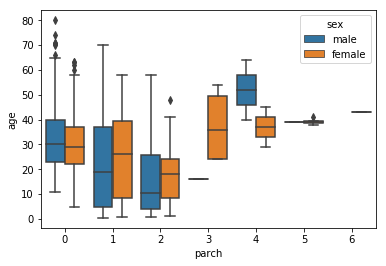

In [29]:
# 箱ひげ図で確認
sns.boxplot(data=df1, x='parch', y='age', hue='sex')

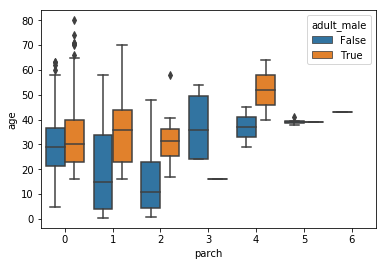

In [30]:
sns.boxplot(data=df1, x='parch', y='age', hue='adult_male')

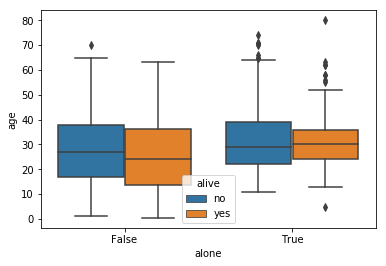

In [31]:
# entropy=1
sns.boxplot(data=df1, x='alone', y='age', hue='alive')

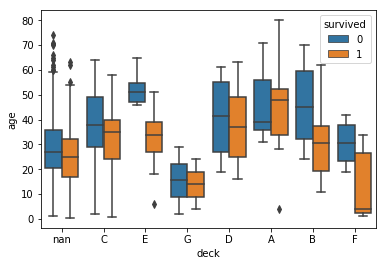

In [32]:
# entropy=0.54
sns.boxplot(data=df1, x='deck', y='age', hue='survived')

In [33]:
gc.collect()

12